# Building Choropleth Maps with GeoPandas
*Mapping Quantities with Color Using Spatial Joins and Data Aggregation*


So far, we've worked a lot with spatial joins—but we haven't yet created one of the most sought-after visualizations in geospatial analysis: the **choropleth**.

A **choropleth** is a type of map where numerical values are represented by varying color shades. Lighter shades represent smaller values; darker shades represent larger ones. They're useful for visualizing things like:
- Population
- Crime rates
- Number of power plants
- Yelp scores
- Goat ownership (seriously)

Let's learn how to build one.


## Step 1: Get the Joined Data
We've already performed a spatial join where each power plant has been associated with the state it's located in.

In [32]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Sample loading (replace with actual paths)
states_url = '../../geopandas_101_DATA/us/cb_2022_us_state_500k.zip'
plants_url = "../../geopandas_101_DATA/us/Power_Plants_in_the_US_5860152164617264051.geojson"

states = gpd.read_file(states_url)
plants = gpd.read_file(plants_url)

states.to_crs(plants.crs, inplace=True)
joined = gpd.sjoin(plants, states, how='inner', predicate='within')


## Step 2: Count Power Plants Per State
We now want to count how many power plants each state contains. This is a classic `.value_counts()` task.


In [33]:
plant_counts = joined['NAME'].value_counts()
plant_counts.head()

NAME
California        1786
New York          1021
Texas              920
North Carolina     919
Minnesota          781
Name: count, dtype: int64


At this point, we have what we need to build a choropleth—almost. We have state names and their associated power plant counts, but we’re missing the **geometry** to draw them.

That means we can’t map yet. So what’s the fix?



You might think, "Let me switch the spatial join and make states the first argument." That way, each row will include **state geometry**, which is what we want to plot.


In [34]:
plants.sindex.valid_query_predicates

{None,
 'contains',
 'contains_properly',
 'covered_by',
 'covers',
 'crosses',
 'dwithin',
 'intersects',
 'overlaps',
 'touches',
 'within'}

In [35]:
# Get state geometry instead of plant points
states_with_plants = gpd.sjoin(states, plants, how='inner', predicate='contains')


Looks good—each row now contains a **state polygon** and plant data.

BUT there's a catch: if we inspect the shape of the resulting GeoDataFrame...


In [36]:
print(states_with_plants.shape)

(13433, 44)



Uh-oh. We now have thousands of rows—one for **each power plant**, each including the same repeated state geometry.

We don’t want thousands of polygons. We want **one polygon per state**.

Time for a better approach.



## Step 3: Return to the Clean States GeoDataFrame
Remember that beautiful, clean `states` GeoDataFrame we started with? It has one shape per state. That’s what we want.

Let’s go back to that and find a way to merge in the plant counts.


In [37]:
states = states.set_index('NAME')


Now that state names are our index, and `plant_counts` is also indexed by state name, we can **assign the values directly**.


In [38]:
states['power_plant_count'] = plant_counts
states = states.sort_values(['power_plant_count'], 
                            ascending=False)
states = states.reset_index()
states.head()

,NAME,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,LSAD,ALAND,AWATER,geometry,power_plant_count
0,California,06,01779778,0400000US06,06,CA,00,403673617862,20291712025,"MULTIPOLYGON (((-118.60442 33.47855, -118.5987...",1786.0
1,New York,36,01779796,0400000US36,36,NY,00,122049084626,19257186417,"MULTIPOLYGON (((-72.0377 41.25128, -72.03472 4...",1021.0
2,Texas,48,01779801,0400000US48,48,TX,00,676685555821,18974391187,"MULTIPOLYGON (((-94.7183 29.72886, -94.71721 2...",920.0
3,North Carolina,37,01027616,0400000US37,37,NC,00,125935585728,13453835222,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...",919.0
4,Minnesota,27,00662849,0400000US27,27,MN,00,206244837557,18937184315,"MULTIPOLYGON (((-89.59206 47.96668, -89.59147 ...",781.0


## Step 4: Plot the Choropleth

(20.0, 75.0)

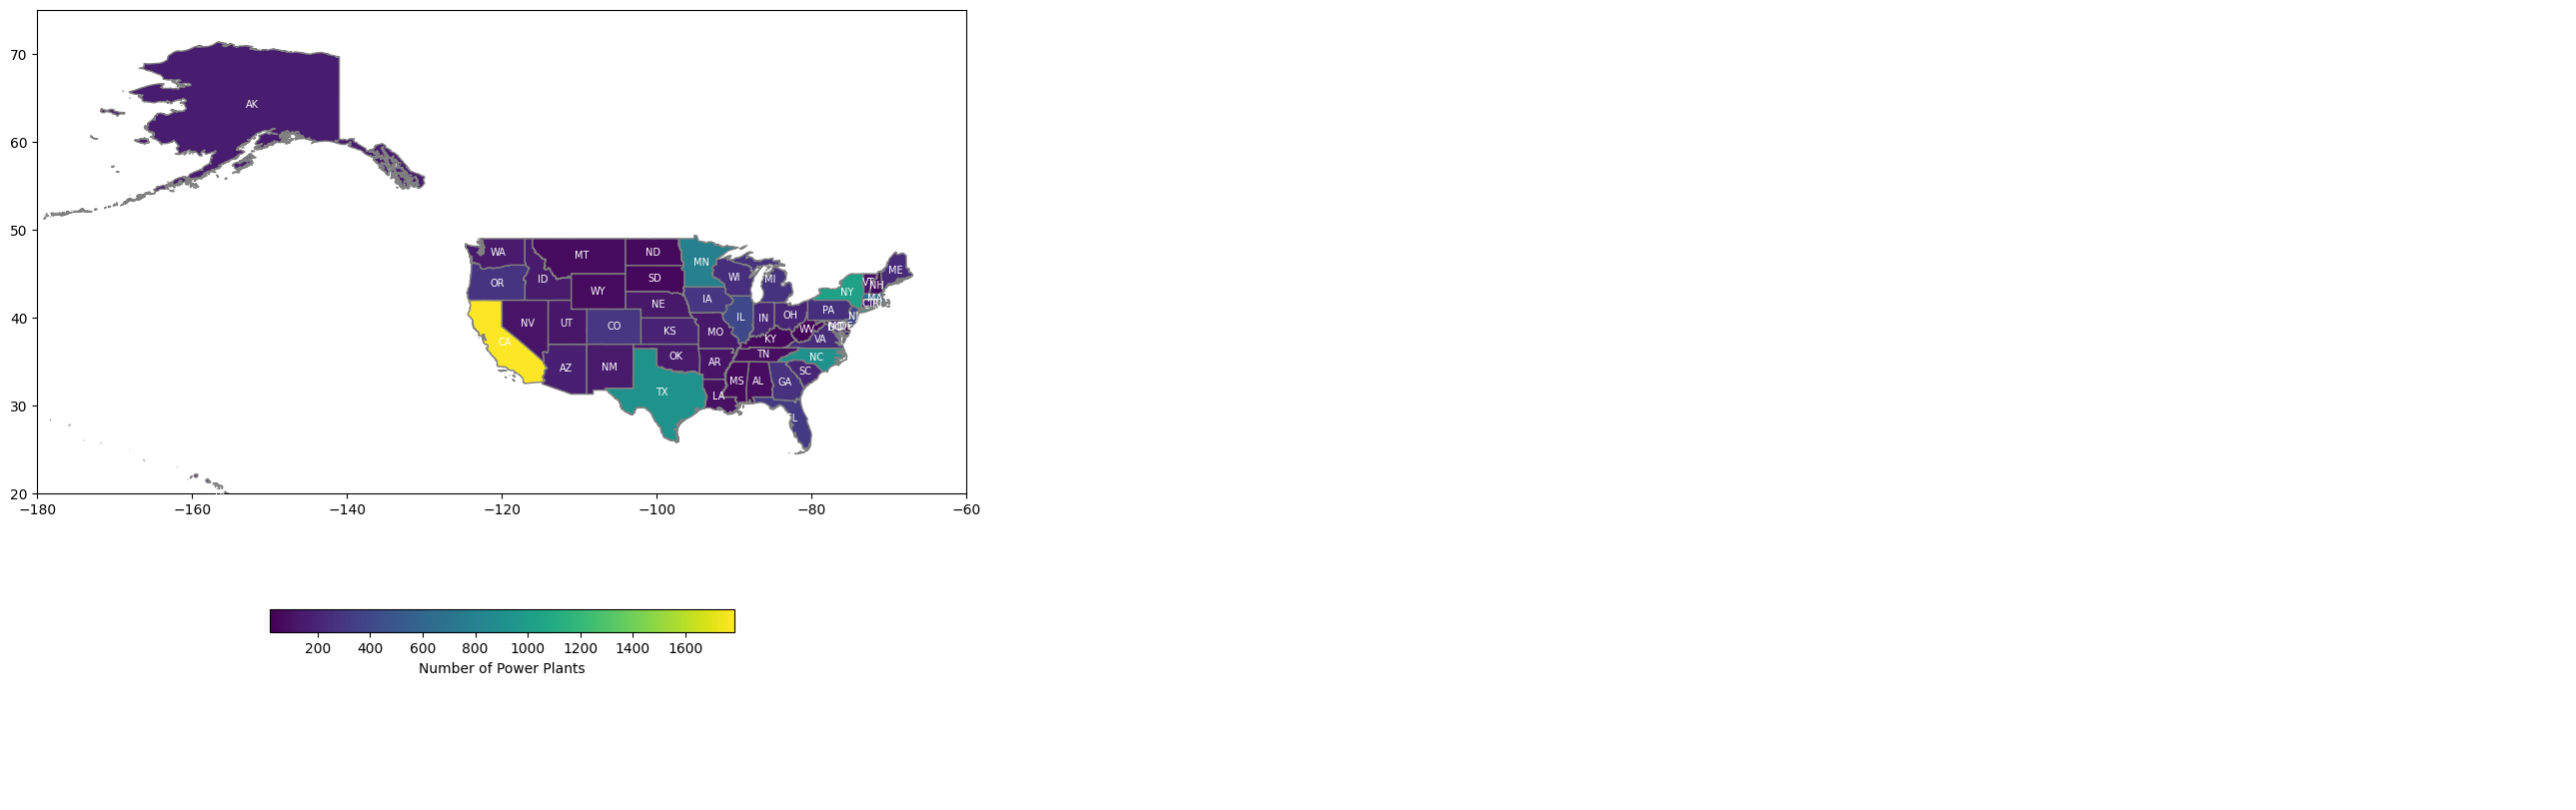

In [99]:
fig, ax = plt.subplots(figsize=(12, 10),)

states.plot(
    ax=ax,
    column='power_plant_count', 
    edgecolor='gray',
    legend=True, 
    legend_kwds={
        'label': 'Number of Power Plants',
        'orientation': 'horizontal',
        'shrink': 0.5
    }
)

for idx, row in states.iterrows():
    centroid = row['geometry'].centroid
    ax.text(
        centroid.x, centroid.y, row['STUSPS'],
        fontsize=7, ha='center', va='center',
        color='white'
    )

    
# ax.axis("off")
ax.set_xlim([-180, -60])  # Approximate longitude bounds for continental US + Alaska
ax.set_ylim([20, 75])     # Approximate latitude bounds


## Bonus: Add Another Variable — Total Megawatts
Now that we know how to summarize, let’s try something more numerical: summing total megawatts by state.


In [ ]:
megawatts_by_state = joined.groupby('name')['megawatts'].sum()
states['megawatts'] = megawatts_by_state

In [ ]:
states.plot(column='megawatts', cmap='OrRd', legend=True, figsize=(20, 20))


## 🧠 Deep Dive: How Did That Assignment Work?
You might be wondering how GeoPandas knew where to put the counts and megawatts.

**Answer: the index.**

When you assign a Series to a DataFrame, Pandas matches rows by index—NOT by row order.

We set the index of `states` to state names. And our summaries are also indexed by state names. So assignment works smoothly:
```python
states['some_column'] = some_series
```
...works **as long as the indexes match**.


## Step 5: Reset Index (Optional)
If you're exporting to CSV or want to access the state name as a normal column, you may want to reset the index.

In [ ]:
states.reset_index(inplace=True)


## ✅ Recap

- Spatial joins can link points (e.g., power plants) to areas (e.g., states).
- Aggregating values per region (e.g., `value_counts`, `groupby().sum()`) gives you something to color.
- Use the clean geometry dataset (one shape per area) for mapping.
- Always match indexes before assigning columns.

🗺️ You now know how to build choropleths from raw point data in GeoPandas!
